*This notebook plots the private network latency contribution as a ratio of hop1 to hop2 latencies.*
- - - 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
import sqlite3
import pandas as pd

In [5]:
DB_LOCATION = 'lastmile.db'

In [6]:
RA_PROBE = 'ra_probe'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [7]:
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_LATENCIES_AGG = 'sk_latencies_agg'
SK_ASN = 'sk_asn'
METADATA_SNAPSHOT = 'metadata_snapshot'
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'

In [8]:
con = sqlite3.connect(DB_LOCATION)

In [9]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , agg.h1_median || ';' || agg.h2_median as h1h2

               FROM   %s                             as  agg
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1
               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [10]:
df_ra.count()

probeid      134724
timestamp    134724
h1h2         130006
dtype: int64

In [11]:
df_ra.head()

,probeid,timestamp,h1h2
0,10006,1406548034,0.429;20.49
1,10006,1406562432,0.431;17.7
2,10006,1406576835,0.438;17.776
3,10006,1406591230,0.478;17.577
4,10006,1406605631,0.422;17.526


In [12]:
query_sk = ''' SELECT     agg.probeid
                        , agg.timestamp
                        , s.asn       
                        , s.asn_holder_name
                        , meta.product                        
                        , agg.h1_avg || ';' || agg.h2_avg as h1h2

                                                                                     
               FROM       %s                            as   agg
                        , %s                            as   api               
                        , %s                            as   ext
                        , %s                            as   s
                        , %s                            as   meta
                        
                        

               WHERE      agg.probeid                    =    ext.probeid
               AND        agg.probeid                    =    api.probeid
               AND        agg.probeid                    =    meta.id               
               AND        api.asn                        =    s.asn               
               
               AND        ext.if_residential             =    1
               AND        agg.h1_avg                     <>   0
               AND        agg.h2_avg                     <>   0
               
           '''%(   SK_LATENCIES_AGG
                 , METADATA_SNAPSHOT_EXTENSIONS                
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_ASN        
                 , METADATA_SNAPSHOT                
               )

df_sk = pd.read_sql(query_sk, con)

In [13]:
df_ra = df_ra.dropna()

In [14]:
df_sk = df_sk.dropna()

In [15]:
df_sk.count()

probeid            435841
timestamp          435841
asn                435841
asn_holder_name    435841
product            435841
h1h2               435841
dtype: int64

In [16]:
df_ra.count()

probeid      130006
timestamp    130006
h1h2         130006
dtype: int64

In [17]:
def calculate_private_contribution(h1h2):
    try: h1,h2 = h1h2.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: contribution = float(h1)/float(h2) *100
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return contribution

In [18]:
df_ra['private_contribution'] = df_ra['h1h2'].apply(calculate_private_contribution)
df_sk['private_contribution'] = df_sk['h1h2'].apply(calculate_private_contribution)

In [19]:
df_ra_groupby = df_ra.groupby('probeid')
df_ra_agg = df_ra_groupby['private_contribution'].agg(['median'])
df_ra_merged = pd.merge(df_ra, df_ra_agg, left_on='probeid', right_index=True)

del df_ra_merged['timestamp']
del df_ra_merged['h1h2']
del df_ra_merged['private_contribution']

df_ra_merged = df_ra_merged.drop_duplicates()
df_ra_merged.rename(columns={'median': 'private_contribution'}, inplace=True)

In [20]:
df_sk_groupby = df_sk.groupby('probeid')
df_sk_agg = df_sk_groupby['private_contribution'].agg(['median'])
df_sk_merged = pd.merge(df_sk, df_sk_agg, left_on='probeid', right_index=True)

del df_sk_merged['timestamp']
del df_sk_merged['h1h2']
del df_sk_merged['private_contribution']

df_sk_merged = df_sk_merged.drop_duplicates()
df_sk_merged.rename(columns={'median': 'private_contribution'}, inplace=True)

In [21]:
df_ra_merged.count()

probeid                 691
private_contribution    691
dtype: int64

In [22]:
df_sk_merged.count()

probeid                 1245
asn                     1245
asn_holder_name         1245
product                 1245
private_contribution    1245
dtype: int64

In [23]:
df_ra_merged = df_ra_merged.sort('private_contribution')
df_sk_merged = df_sk_merged.sort('private_contribution')

In [24]:
df_ra_merged[df_ra_merged.private_contribution >= 100].count()

probeid                 3
private_contribution    3
dtype: int64

In [25]:
df_sk_merged[df_sk_merged.private_contribution >= 100].count()

probeid                 124
asn                     124
asn_holder_name         124
product                 124
private_contribution    124
dtype: int64

In [29]:
df_ra_merged['private_contribution'].values[1]

0.75822102314089923

In [30]:
import Cdf
import Pmf
ra_sample = df_ra_merged['private_contribution'].values
sk_sample = df_sk_merged['private_contribution'].values
ra_c = Cdf.MakeCdfFromList(ra_sample)
sk_c = Cdf.MakeCdfFromList(sk_sample)

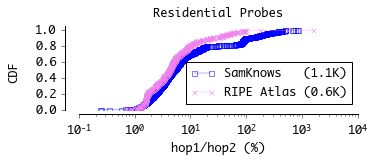

In [50]:
# ---- plt.style.use('ggplot')
fig = plt.figure(figsize=(5,1.5))
plt.rcParams['font.size'] = 12
yticks = np.arange(0,1.1,0.2)
ax = plt.gca()

ax.plot (  sk_c.xs
          , sk_c.ps
          , marker='s'
          , linewidth=0.3
          , markersize=5
          , fillstyle='none'
          , color='Blue'
         )

ax.plot (  ra_c.xs
          , ra_c.ps
          , marker='x'
          , linewidth=0.3
          , markersize=5
          , color='Violet'
         )

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax.yaxis.set_label_coords(-0.21, 0.45)
ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_ylim([0,1.05])
#ax.set_xlim(xmin=100)
ax.set_xscale('log')
ax.set_xlabel('hop1/hop2 (%)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)
ax.legend(['SamKnows   (1.1K)', 'RIPE Atlas (0.6K)'], fontsize=12, bbox_to_anchor=(0.9, -0.55))
ax.legend(['SamKnows   (1.1K)', 'RIPE Atlas (0.6K)'], fontsize=12, loc='best')
plt.title('Residential Probes', fontsize=12, y=1.05)
plt.savefig('ripeatlas-samknows-private-contribution.pdf', format='pdf', bbox_inches='tight')